In [1]:
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
from model import VariationalLayer, VariationalNet

from train import TrainDecoupledElbo

In [2]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 0
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [3]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [4]:
N = 5000
N_train = 3000
N_valid = N - N_train

In [5]:
X, y = data_generator.data_4to4(N)
X, y_perfect = data_generator.data_4to4(N, noise_level=0)

### Plot if output data is 1D
pca = PCA(n_components=1)
pca.fit(X)
X_plot = pca.transform(X)

fig,ax = plt.subplots(figsize=(6,3), dpi=120)
plt.scatter(X_plot, y, c='blue', alpha=0.2, s=5)
plt.scatter(X_plot, y_perfect, c='r', alpha=0.7, s=0.3)

In [6]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [7]:
dataset = data_generator.ArtificialDataset(X, y)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_valid])

BATCH_SIZE_LOADER = 64

training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

In [8]:
n_samples = 10
input_size = X.shape[1]
output_size = y.shape[1]

K = 1
plv = 3

BATCH_SIZE = 64

In [9]:
h = VariationalNet(n_samples, input_size, output_size, plv).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.005)
mse_loss_sum = nn.MSELoss(reduction='sum')

In [10]:
train_elbo = TrainDecoupledElbo(
                model=h,
                opt=opt_h,
                loss_data=mse_loss_sum,
                K=K,
                training_loader=training_loader,
                validation_loader=validation_loader
            )

In [11]:
train_elbo.train()

------------------EPOCH 1------------------
DATA LOSS 	 train 516.66 valid 455.9
KL LOSS 	 train 59.48 valid 59.51
ELBO LOSS 	 train 576.15 valid 515.4
------------------EPOCH 2------------------
DATA LOSS 	 train 438.98 valid 439.74
KL LOSS 	 train 57.1 valid 57.09
ELBO LOSS 	 train 496.09 valid 496.83
------------------EPOCH 3------------------
DATA LOSS 	 train 427.64 valid 431.58
KL LOSS 	 train 54.78 valid 54.72
ELBO LOSS 	 train 482.42 valid 486.3
------------------EPOCH 4------------------
DATA LOSS 	 train 423.38 valid 431.85
KL LOSS 	 train 52.46 valid 52.38
ELBO LOSS 	 train 475.83 valid 484.23
------------------EPOCH 5------------------
DATA LOSS 	 train 422.76 valid 427.86
KL LOSS 	 train 50.17 valid 50.1
ELBO LOSS 	 train 472.93 valid 477.96
------------------EPOCH 6------------------
DATA LOSS 	 train 421.26 valid 427.49
KL LOSS 	 train 48.0 valid 47.94
ELBO LOSS 	 train 469.26 valid 475.43
------------------EPOCH 7------------------
DATA LOSS 	 train 420.34 valid 428.37


DATA LOSS 	 train 419.19 valid 431.26
KL LOSS 	 train 18.32 valid 18.66
ELBO LOSS 	 train 437.51 valid 449.92
------------------EPOCH 55------------------
DATA LOSS 	 train 419.15 valid 432.98
KL LOSS 	 train 18.23 valid 18.52
ELBO LOSS 	 train 437.37 valid 451.49
------------------EPOCH 56------------------
DATA LOSS 	 train 419.48 valid 430.28
KL LOSS 	 train 18.11 valid 18.41
ELBO LOSS 	 train 437.6 valid 448.68
------------------EPOCH 57------------------
DATA LOSS 	 train 419.4 valid 429.83
KL LOSS 	 train 17.96 valid 18.32
ELBO LOSS 	 train 437.36 valid 448.15
------------------EPOCH 58------------------
DATA LOSS 	 train 417.84 valid 431.82
KL LOSS 	 train 17.88 valid 18.18
ELBO LOSS 	 train 435.72 valid 450.0
------------------EPOCH 59------------------
DATA LOSS 	 train 418.54 valid 429.59
KL LOSS 	 train 17.76 valid 18.1
ELBO LOSS 	 train 436.3 valid 447.69
------------------EPOCH 60------------------
DATA LOSS 	 train 418.74 valid 430.53
KL LOSS 	 train 17.66 valid 17.98
ELB

DATA LOSS 	 train 418.75 valid 432.49
KL LOSS 	 train 14.36 valid 14.63
ELBO LOSS 	 train 433.11 valid 447.13
------------------EPOCH 108------------------
DATA LOSS 	 train 417.98 valid 430.26
KL LOSS 	 train 14.33 valid 14.61
ELBO LOSS 	 train 432.31 valid 444.87
------------------EPOCH 109------------------
DATA LOSS 	 train 419.26 valid 430.81
KL LOSS 	 train 14.28 valid 14.58
ELBO LOSS 	 train 433.53 valid 445.39
------------------EPOCH 110------------------
DATA LOSS 	 train 417.4 valid 431.38
KL LOSS 	 train 14.22 valid 14.49
ELBO LOSS 	 train 431.63 valid 445.86
------------------EPOCH 111------------------
DATA LOSS 	 train 419.22 valid 431.26
KL LOSS 	 train 14.19 valid 14.42
ELBO LOSS 	 train 433.41 valid 445.68
------------------EPOCH 112------------------
DATA LOSS 	 train 417.49 valid 431.64
KL LOSS 	 train 14.15 valid 14.43
ELBO LOSS 	 train 431.65 valid 446.07
------------------EPOCH 113------------------
DATA LOSS 	 train 417.8 valid 430.93
KL LOSS 	 train 14.1 valid 1

def plot_test_curve(X_test, y_test, h):
    xt = torch.hstack(
    (X_test[:,0], 
     torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
     torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))
    
    plt.scatter(X_test[:,0].detach(), y_test.detach())
    for i in range(0, 100):
        plt.scatter(xt.detach(), 
                    h(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        plt.ylim([-10, 10])
        
        
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)

In [12]:
M = 100

In [13]:
Y_pred = h(validation_loader.dataset.dataset.X)
for i in range(1,int(M/h.n_samples)):
    Y_pred = torch.vstack((Y_pred, h(validation_loader.dataset.dataset.X)))
    
y_test = validation_loader.dataset.dataset.y

In [14]:
# Demand distribution
demand_pred_distribution = Y_pred[:,:,0]
demand_true = y_test[:,0]

In [15]:
def profit(order, sell_price, cost_price):
    return sell_price*torch.minimum(order, demand_true) - cost_price*order

In [26]:
sp = 200

zEypred_list = []
zypred_list = []
zy_list = []
cp_list = list(np.arange(20,190,10))
qtl_list = []

for cp in cp_list:

    # Classical newsvendor problem
    sell_price = torch.tensor(sp)
    cost_price = torch.tensor(cp)
    quantile_cut = (sell_price - cost_price)/sell_price
    optimal_pred_order = torch.quantile(demand_pred_distribution, quantile_cut, dim=0)
    optimal_order = demand_true

    zEypred = round(profit(
        demand_pred_distribution.mean(), 
        sell_price, cost_price
    ).sum().item(), 2)

    zypred = round(profit(
        optimal_pred_order, 
        sell_price, cost_price
    ).sum().item(), 2)

    zy = round(profit(
        optimal_order, 
        sell_price, cost_price
    ).sum().item(), 2)
    
    qtl_list.append(quantile_cut.item())
    
    zEypred_list.append((zy-zEypred)/zy)
    zypred_list.append((zy-zypred)/zy)

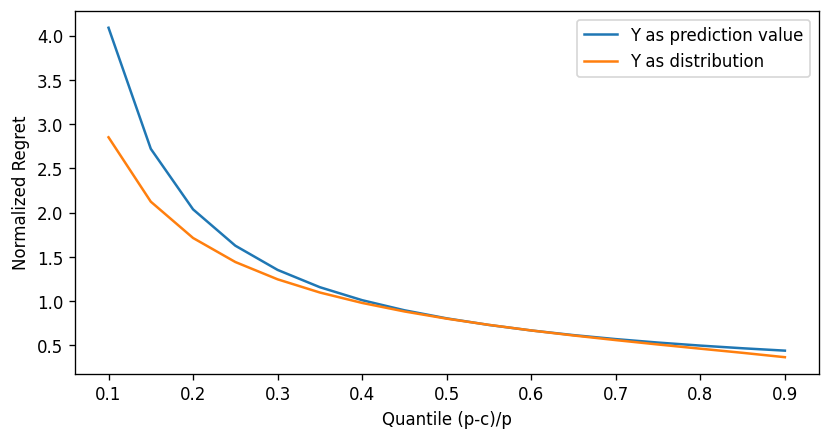

In [27]:
fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.set_xlabel('Quantile (p-c)/p')
ax.set_ylabel('Normalized Regret')
ax.plot(qtl_list, zEypred_list, label = 'Y as prediction value')
ax.plot(qtl_list, zypred_list, label = 'Y as distribution')
ax.legend()